# CZ1115 - Team WIN Data Science Project 

### Model Name: multinomial Naive Bayes & Linear Support Vector Classification [MNB & LSVC]

--- 

> **As seen in M1, our Natural Language Proccessing - Multi-Label Classifier did pretty well in predicting genres based on the overviews based on the data we obtained (Accuracy and F1 Score). But we have yet to achieve our goal and it is still too early to say it is the best model to use for genre predictor. We will now be exploring more models, in our case, the multinomial Naive Bayes & Linear Support Vector Classification.**

#####**1. Data Extraction: API CALLING**

In [1]:
import requests,json,csv,os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

In [2]:
import time

discover_api_url = 'https://api.themoviedb.org/3/discover/movie?api_key=9c9de4f24b3a171f5962aaa463a6b351&language=en-Us&without_genres=12,16,28,80,10751,14,36,27,10402,9648,878,10770,10752,37'


discover_api = requests.get(discover_api_url).json()
movies = discover_api["results"]
for page in range(2, discover_api["total_pages"]+1): # if want all pages, change end range to "discover_api["total_pages"]+1"
    try:
      discover_api = requests.get(discover_api_url + f"&page={page}").json()
      movies.extend(discover_api["results"])
    except requests.exceptions.ConnectionError:
      requests.status_code = "Connection refused"
      time.sleep(0.01)

titles = []
for i , film in enumerate(movies):
  titles.append(film['original_title'])
overviews = []
for i , film in enumerate(movies):
  overviews.append(film['overview'])
genres = []
for i , film in enumerate(movies):
  genres.append(film['genre_ids'])

#get genre movie list from TMDb (to convert ID to name of genre)
discover_genre_api_url = 'https://api.themoviedb.org/3/genre/movie/list?api_key=9c9de4f24b3a171f5962aaa463a6b351&language=en-US'
discover_genre_api = requests.get(discover_genre_api_url).json()
genre_list = discover_genre_api["genres"]
time.sleep(0.01)
for page in range(2, discover_api["total_pages"]+1): # if want all pages, change end range to "discover_api["total_pages"]+1"
    try:
      discover_genre_api = requests.get(discover_genre_api_url + f"&page={page}").json()
      genre_list.extend(discover_genre_api["genres"])
    except requests.exceptions.ConnectionError:
      requests.status_code = "Connection refused"
      time.sleep(0.01)

#make it a dictionary
dict = {}
remove_list = []
j = 0
for i, film in enumerate(genre_list):
    dict[film['id']] = film['name']

#convert genre IDs to names
for i in range(len(genres)):
    for j in range(len(genres[i])):

      genres[i][j] = dict[genres[i][j]]

dat = {'titles': titles, 'overviews': overviews, 'genres': genres}
df = pd.DataFrame(data=dat)

empty = (df.loc[df['genres'].str.len()<1])

for i, row in enumerate(df['genres']):
  if row == []:
    df = df.drop([i])

In [3]:
df2 = df.explode('genres')
df2.dropna(subset = ["genres"], inplace=True)

#####**2. Data Cleaning**

Python NLTK provides WordNet Lemmatizer that uses the WordNet Database to lookup lemmas of words

In [4]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
from nltk.stem import WordNetLemmatizer

import re
#import en
import sys

wordnet_lemmatizer = WordNetLemmatizer()

# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # put text to lowercase
    text = text.lower() 
    x = text.split()

    for i, j in enumerate(x):
      x[i] = wordnet_lemmatizer.lemmatize(j,pos="v")

    # remove whitespaces 
    text = ' '.join(x) 
    
    return text

df['clean_overview'] = df['overviews'].apply(lambda x: clean_text(x))
#df2['clean_overview'] = df2['overviews'].apply(lambda x: clean_text(x))
df

,titles,overviews,genres,clean_overview
0,Bad Trip,Two pals embark on a road trip full of funny p...,[Comedy],two pal embark on a road trip full of funny pr...
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,"[Comedy, Romance]",incurable romantic lotte find her life upend w...
2,After We Collided,Tessa finds herself struggling with her compli...,"[Romance, Drama]",tessa find herself struggle with her complicat...
3,Coming 2 America,Prince Akeem Joffer is set to become King of Z...,[Comedy],prince akeem joffer be set to become king of z...
4,彼女,Rei helps the woman she's been in love with fo...,"[Drama, Romance, Thriller]",rei help the woman shes be in love with for ye...
...,...,...,...,...
9995,Alcatraz: Search for the Truth,More than 50 years after three men broke out o...,[Documentary],more than years after three men break out of t...
9996,The Good Humor Man,A mischievous high school sophomore faces a co...,[Comedy],a mischievous high school sophomore face a con...
9997,내 사랑 싸가지,After being dumped by her boyfriend just befor...,"[Comedy, Romance]",after be dump by her boyfriend just before the...
9998,The Green Fog,A tribute to a fascinating film shot by Alfred...,[Documentary],a tribute to a fascinate film shoot by alfred ...


In [6]:
df.dtypes

titles            object
overviews         object
genres            object
clean_overview    object
dtype: object

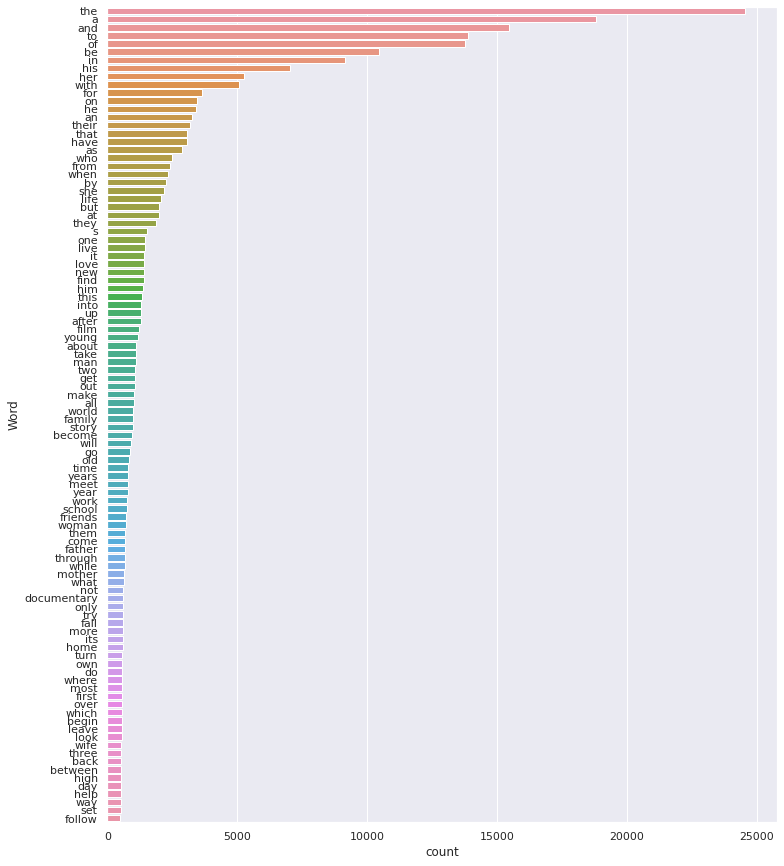

In [7]:

import seaborn as sns

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()

  # text = " ".join(word for word in d.word)
  # wordcloud = WordCloud().generate(text)
  # # Show wordcloud
  # plt.imshow(wordcloud, interpolation='bilinear')
  # plt.axis("off")
  # plt.show()
  
# print 100 most frequent words 
#freq_words(df2['clean_overview'], 100)
freq_words(df['clean_overview'], 100)

Most of the terms in the above plot are stopwords. These stopwords carry far less meaning than other keywords in the text (they just add noise to the data). I’m going to go ahead and remove them from the plots’ text. You can download the list of stopwords from the nltk library:

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#df2['clean_overview'] = df2['clean_overview'].apply(lambda x: remove_stopwords(x))
df['clean_overview'] = df['clean_overview'].apply(lambda x: remove_stopwords(x))

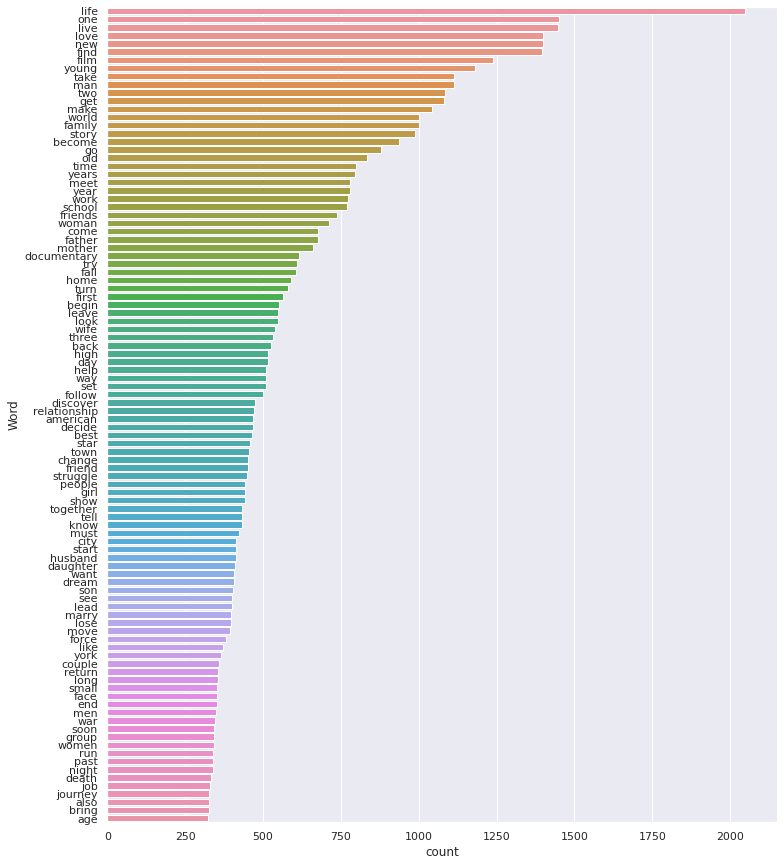

In [10]:
#freq_words(df2['clean_overview'], 100)
freq_words(df['clean_overview'], 100)

#####**3. Data Visualization**

In [11]:
##df_array = df.copy() **EXTRA**
df['GenresCount'] = df['genres'].apply(len)
max(df['GenresCount'])

4

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer


df['genres'] = df['genres'].apply(lambda x: ','.join(map(str, x)))

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'].dropna().str.split(','))

print(mlb.classes_)

['Comedy' 'Documentary' 'Drama' 'Romance' 'Thriller']


In [13]:
df2['Count']=0
gn_show=df2[['genres','Count']].groupby(['genres'],as_index=False).count().sort_values(['Count'], ascending=False).head(10)
gn_show

,genres,Count
2,Drama,4764
0,Comedy,3941
3,Romance,2359
1,Documentary,2131
4,Thriller,925


In [14]:
TotalCountGenres=sum(gn_show['Count'])
TotalCountGenres
gn_show['Frequency'] = gn_show['Count']/TotalCountGenres
gn_show['CumulativeFrequency'] = gn_show['Frequency'].cumsum()
gn_show.head(20)

,genres,Count,Frequency,CumulativeFrequency
2,Drama,4764,0.337394,0.337394
0,Comedy,3941,0.279108,0.616501
3,Romance,2359,0.167068,0.783569
1,Documentary,2131,0.150921,0.934490
4,Thriller,925,0.065510,1.000000


In [15]:
np.array(gn_show[gn_show['CumulativeFrequency']<=1.01]['genres'])

array(['Drama', 'Comedy', 'Romance', 'Documentary', 'Thriller'],
      dtype=object)

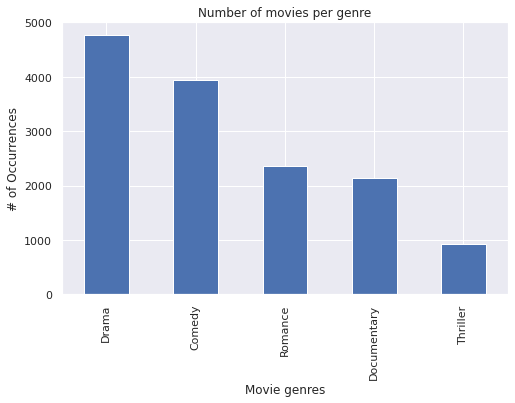

In [16]:
gn_show[gn_show['CumulativeFrequency']<=1.01][['genres','Count']].plot(x='genres', y='Count', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

In [17]:
##show max category a movie can have
print("Maximum number of category a movie can have is: ", max(df['GenresCount']))
##print(max(df['GenresCount']))
df[df['GenresCount']==max(df['GenresCount'])]
##df[df['GenresCount']==3].count()

Maximum number of category a movie can have is:  4


,titles,overviews,genres,clean_overview,GenresCount
4655,Showgirls 2: Penny's from Heaven,"Las Vegas stripper, Penny Slot (Rena Riffel), ...","Comedy,Drama,Romance,Thriller",las vegas stripper penny slot rena riffel set ...,4
5145,Rich and Strange,An unexpected inheritance proves less than a b...,"Comedy,Romance,Drama,Thriller",unexpected inheritance prove less boon young m...,4
6915,Wild Side,A bank accountant who moonlights as a high-pri...,"Thriller,Drama,Comedy,Romance",bank accountant moonlight high price call girl...,4
7260,Shooting Gallery,A street-smart pool player falls in with a pac...,"Comedy,Drama,Thriller,Romance",street smart pool player fall pack hustlers ri...,4
9181,"Cor, Blimey!",Dramatisation of the love affair between Sidne...,"Comedy,Documentary,Drama,Romance",dramatisation love affair sidney jam barbara w...,4


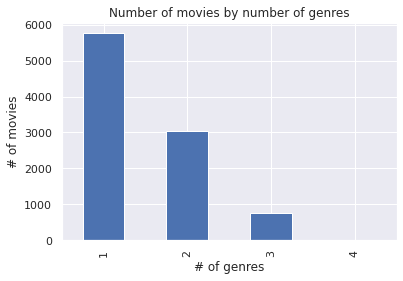

In [18]:
df['GenresCount'].value_counts().plot(kind='bar')

plt.title("Number of movies by number of genres")
plt.ylabel('# of movies', fontsize=12)
plt.xlabel('# of genres', fontsize=12)
plt.show()

####**4. Machine Learning**

In [19]:
mainGenres=np.array(gn_show[gn_show['CumulativeFrequency']<=1.01]['genres'])

In [20]:
arr1=np.array(['Drama', 'Comedy','Romance','Documentary','Thriller'])
arr1[np.in1d(arr1,mainGenres)] # genres not in the mainGenres array will be deleted

array(['Drama', 'Comedy', 'Romance', 'Documentary', 'Thriller'],
      dtype='<U11')

In [21]:
df.head()

,titles,overviews,genres,clean_overview,GenresCount
0,Bad Trip,Two pals embark on a road trip full of funny p...,Comedy,two pal embark road trip full funny prank pull...,1
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,"Comedy,Romance",incurable romantic lotte find life upend plan ...,2
2,After We Collided,Tessa finds herself struggling with her compli...,"Romance,Drama",tessa find struggle complicate relationship ha...,2
3,Coming 2 America,Prince Akeem Joffer is set to become King of Z...,Comedy,prince akeem joffer set become king zamunda di...,1
4,彼女,Rei helps the woman she's been in love with fo...,"Drama,Romance,Thriller",rei help woman shes love years escape abusive ...,3


Let's try to extract some keywords / features from a simple text first

In [22]:
txt = ["He is ::having a great Time, at the park time?",
       "She, unlike most women, is a big player on the park's grass.",
       "she can't be going"]

txt

['He is ::having a great Time, at the park time?',
 "She, unlike most women, is a big player on the park's grass.",
 "she can't be going"]

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

# Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None)

In [24]:
count_train = count_vec.fit(txt)
bag_of_words = count_vec.transform(txt)

# Print the first 10 features of the count_vec
print("Every feature:\n{}".format(count_vec.get_feature_names()))
print("\nEvery 3rd feature:\n{}".format(count_vec.get_feature_names()[::3]))

Every feature:
['big', 'going', 'grass', 'great', 'having', 'park', 'player', 'time', 'unlike', 'women']

Every 3rd feature:
['big', 'great', 'player', 'women']


In [25]:
count_vec.fit_transform(txt).toarray()

array([[0, 0, 0, 1, 1, 1, 0, 2, 0, 0],
       [1, 0, 1, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [26]:
count_vec.get_feature_names()[:3]

['big', 'going', 'grass']

In order to do machine learning we have to convert the genres (text) into binary form (0 and 1) for easier computation and comparison

In [27]:
df.head()

,titles,overviews,genres,clean_overview,GenresCount
0,Bad Trip,Two pals embark on a road trip full of funny p...,Comedy,two pal embark road trip full funny prank pull...,1
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,"Comedy,Romance",incurable romantic lotte find life upend plan ...,2
2,After We Collided,Tessa finds herself struggling with her compli...,"Romance,Drama",tessa find struggle complicate relationship ha...,2
3,Coming 2 America,Prince Akeem Joffer is set to become King of Z...,Comedy,prince akeem joffer set become king zamunda di...,1
4,彼女,Rei helps the woman she's been in love with fo...,"Drama,Romance,Thriller",rei help woman shes love years escape abusive ...,3


In [28]:
#z = movies.GenreSplitMain.str.split()
##df.genres[0:15].apply(lambda x: ''.join(x)).str.split(pat=',',n=5,expand=True)
df.genres.apply(lambda x: ''.join(x)).str.split(pat=',',n=5,expand=True)

,0,1,2,3
0,Comedy,None,None,None
1,Comedy,Romance,None,None
2,Romance,Drama,None,None
3,Comedy,None,None,None
4,Drama,Romance,Thriller,None
...,...,...,...,...
9995,Documentary,None,None,None
9996,Comedy,None,None,None
9997,Comedy,Romance,None,None
9998,Documentary,None,None,None


In [29]:
##df.genres[3:15].apply(lambda x: ''.join(x)).str.get_dummies(sep=',')
df.genres.apply(lambda x: ''.join(x)).str.get_dummies(sep=',')

,Comedy,Documentary,Drama,Romance,Thriller
0,1,0,0,0,0
1,1,0,0,1,0
2,0,0,1,1,0
3,1,0,0,0,0
4,0,0,1,1,1
...,...,...,...,...,...
9995,0,1,0,0,0
9996,1,0,0,0,0
9997,1,0,0,1,0
9998,0,1,0,0,0


In [30]:
df.genres[0:15]

0                     Comedy
1             Comedy,Romance
2              Romance,Drama
3                     Comedy
4     Drama,Romance,Thriller
5                     Comedy
6                   Thriller
7             Drama,Thriller
8               Drama,Comedy
9             Drama,Thriller
11                  Thriller
12                    Comedy
13             Drama,Romance
14             Romance,Drama
15      Romance,Drama,Comedy
Name: genres, dtype: object

**Building the classification algorithms**

Building the classes: one dummy variable for each genre. In this final project, there are 5 genres of movies.
Split the data in Train and Test
Building the features based on TfidfVectorizer

**Dummy classes**

In [31]:
# the dummy classes
df = pd.concat([df, df.genres.apply(lambda x: ''.join(x)).str.get_dummies(sep=',')], axis=1)
df

,titles,overviews,genres,clean_overview,GenresCount,Comedy,Documentary,Drama,Romance,Thriller
0,Bad Trip,Two pals embark on a road trip full of funny p...,Comedy,two pal embark road trip full funny prank pull...,1,1,0,0,0,0
1,Just Say Yes,Incurable romantic Lotte finds her life upende...,"Comedy,Romance",incurable romantic lotte find life upend plan ...,2,1,0,0,1,0
2,After We Collided,Tessa finds herself struggling with her compli...,"Romance,Drama",tessa find struggle complicate relationship ha...,2,0,0,1,1,0
3,Coming 2 America,Prince Akeem Joffer is set to become King of Z...,Comedy,prince akeem joffer set become king zamunda di...,1,1,0,0,0,0
4,彼女,Rei helps the woman she's been in love with fo...,"Drama,Romance,Thriller",rei help woman shes love years escape abusive ...,3,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
9995,Alcatraz: Search for the Truth,More than 50 years after three men broke out o...,Documentary,years three men break worlds toughest penitent...,1,0,1,0,0,0
9996,The Good Humor Man,A mischievous high school sophomore faces a co...,Comedy,mischievous high school sophomore face conflic...,1,1,0,0,0,0
9997,내 사랑 싸가지,After being dumped by her boyfriend just befor...,"Comedy,Romance",dump boyfriend day anniversary ha young meet c...,2,1,0,0,1,0
9998,The Green Fog,A tribute to a fascinating film shot by Alfred...,Documentary,tribute fascinate film shoot alfred hitchcock ...,1,0,1,0,0,0


**train_test_split**

In [32]:
from sklearn.model_selection import train_test_split
# the train and the test data set will be build when there is at least one genre for a movie
MoviesTrain, MoviesTest = train_test_split(df, random_state=9, test_size=0.2, shuffle=True)

**Features**

In [33]:
# definition the algorithm for feature extraction
tfidf = TfidfVectorizer(stop_words ='english', smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')

In [34]:
# building the features
x_train = tfidf.fit_transform(MoviesTrain.clean_overview) 
x_test  = tfidf.transform(MoviesTest.clean_overview)
### for test data, the feature extraction will be done through the function transform()
### to make sure there is no features dimensionality mismatch

In [35]:
print('nrow of the MoviesTrain ={}'. format(MoviesTrain.shape[0]))
print(MoviesTrain.head())

nrow of the MoviesTrain =7645
                  titles  ... Thriller
2055        The Red Pill  ...        0
5804      Run Ronnie Run  ...        0
1768       Sorority Boys  ...        0
7376  What Lies Upstream  ...        0
3427        Touchy Feely  ...        0

[5 rows x 10 columns]


In [36]:
print('nrow of the MoviesTest ={}'. format(MoviesTest.shape[0]))
print(MoviesTest.head())

nrow of the MoviesTest =1912
            titles  ... Thriller
1964     The Padre  ...        0
5307  Libeled Lady  ...        0
2560  Delivery Man  ...        0
3292   Sługi wojny  ...        1
6038  Forever Lulu  ...        0

[5 rows x 10 columns]


In [37]:
type(x_train)

scipy.sparse.csr.csr_matrix

In [38]:
x_train.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
tfidf.inverse_transform(x_train[0].toarray())

[array(['alternate', 'begin', 'beliefs', 'cassie', 'chronicle', 'document',
        'equality', 'explore', 'feminist', 'filmmaker', 'gender', 'jaye',
        'journey', 'men', 'movement', 'mysterious', 'perspective',
        'polarize', 'power', 'privilege', 'question', 'right', 'set',
        'world'], dtype='<U20')]

In [40]:
print('The corpus is huge. It contain {} words.'.format(len(x_train[0].toarray()[0])))

The corpus is huge. It contain 22432 words.


In [41]:
# building the classes
y_train = MoviesTrain[MoviesTrain.columns[1:]]
y_test = MoviesTest[MoviesTest.columns[1:]]
print(y_train.shape)
print(y_test.shape)

(7645, 9)
(1912, 9)


In [42]:
len(y_train.columns)
y_train.head()

,overviews,genres,clean_overview,GenresCount,Comedy,Documentary,Drama,Romance,Thriller
2055,When a feminist filmmaker sets out to document...,Documentary,feminist filmmaker set document mysterious pol...,1,0,1,0,0,0
5804,A redneck with an uncanny knack for getting ar...,Comedy,redneck uncanny knack get arrest become star r...,1,1,0,0,0,0
1768,After being falsely accused of stealing the bu...,Comedy,falsely accuse steal budget annual cocktail cr...,1,1,0,0,0,0
7376,"In this detective story, filmmaker Cullen Hoba...",Documentary,detective story filmmaker cullen hoback invest...,1,0,1,0,0,0
3427,Abby is a sought after massage therapist and a...,Drama,abby seek massage therapist free spirit brothe...,1,0,0,1,0,0


In [43]:
len(y_test.columns)
print(y_test.head())

                                              overviews  ... Thriller
1964  American retired Judge Randall Nemes and his h...  ...        0
5307  When a major newspaper accuses wealthy sociali...  ...        0
2560  An affable underachiever finds out he's father...  ...        0
3292                                                     ...        1
6038  A schizophrenic romantic tracks down her colle...  ...        0

[5 rows x 9 columns]


######**4.1 Multinomial Naive Bayes Classification**

Quick check of the multinomial Naive Bayes Classification

In [44]:
multinomialNB=OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [45]:
# fitting
multinomialNB.fit(x_train, y_train.Thriller)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)

In [46]:
# compute the testing accuracy
prediction = multinomialNB.predict(x_test)

In [47]:
print("Possible genre predictions:")
print()
for i in range(0,len(arr1)):
  print(arr1[i])

print(len(prediction))

Possible genre predictions:

Drama
Comedy
Romance
Documentary
Thriller
1912


In [48]:
print('Test accuracy is {}'.format(accuracy_score(y_test.Thriller, prediction)))

Test accuracy is 0.8849372384937239


In [49]:
len(mainGenres)

5

**Multinomial Naive Bayes Classification for all the movie genres**

In [50]:
accuracy_multinomialNB=pd.DataFrame(columns=['Genre', 'accuracy_multinomialNB'])
accuracy_multinomialNB.head()

,Genre,accuracy_multinomialNB


In [51]:
##To add titles to the df table
ToPredict = y_test.copy()
ToPredict['Predicted_Genres'] = [[] for x in ToPredict.index]
t = MoviesTest["titles"]
ToPredict_Tiltes = pd.concat([t,ToPredict],axis=1)

In [52]:
#print(ToPredict_Tiltes.index)
print(type(y_test['Drama']))

<class 'pandas.core.series.Series'>


In [53]:
i=0

for genre in mainGenres:
    multinomialNB.fit(x_train, y_train[genre])
    prediction = multinomialNB.predict(x_test)
    accuracy_multinomialNB.loc[i,'Genre'] = genre
    accuracy_multinomialNB.loc[i,'accuracy_multinomialNB'] = accuracy_score(y_test[genre], prediction)
    i=i+1

    j=0;
    for row in ToPredict_Tiltes.index: #1904 total
        if(prediction[j]==1):
          ToPredict_Tiltes.loc[row,'Predicted_Genres'].append(genre)
        j=j+1

accuracy_multinomialNB

,Genre,accuracy_multinomialNB
0,Drama,0.702406
1,Comedy,0.748431
2,Romance,0.76046
3,Documentary,0.903766
4,Thriller,0.884937


Below is sneak peek of some original genres VS predicted genres

In [54]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_withpre = pd.DataFrame(ToPredict_Tiltes, columns = ["titles","clean_overview", "genres", 'Predicted_Genres'])
df_withpre.head()

,titles,clean_overview,genres,Predicted_Genres
1964,The Padre,american retire judge randall nemes hire gun g...,Drama,[Drama]
5307,Libeled Lady,major newspaper accuse wealthy socialite conni...,"Comedy,Romance","[Drama, Comedy, Romance]"
2560,Delivery Man,affable underachiever find hes father children...,Comedy,"[Comedy, Romance]"
3292,Sługi wojny,,Thriller,[]
6038,Forever Lulu,schizophrenic romantic track college sweethear...,"Drama,Comedy,Romance","[Drama, Comedy, Romance]"


In [55]:
temp = df_withpre.copy()
temp['Predicted_Genres'] = temp['Predicted_Genres'].apply(lambda x: ','.join(map(str, x)))

In [56]:
mlb_actual = MultiLabelBinarizer()
actual = mlb_actual.fit_transform(temp['genres'].dropna().str.split(','))
print(mlb_actual.classes_)
print("----------------------------------------------------")
print(actual)

['Comedy' 'Documentary' 'Drama' 'Romance' 'Thriller']
----------------------------------------------------
[[0 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 0]
 ...
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]


In [57]:
from sklearn import preprocessing
#mlb = MultiLabelBinarizer()
# mlb = preprocessing.MultiLabelBinarizer(classes=("Comedy","Documentary","Drama","Romance","Thriller"))
mlb_predicted = preprocessing.MultiLabelBinarizer(classes=mlb_actual.classes_)
predicted = mlb_predicted.fit_transform(temp['Predicted_Genres'].dropna().str.split(','))
print(mlb_predicted.classes_)
print("----------------------------------------------------")
print(predicted)

['Comedy' 'Documentary' 'Drama' 'Romance' 'Thriller']
----------------------------------------------------
[[0 0 1 0 0]
 [1 0 1 1 0]
 [1 0 0 1 0]
 ...
 [0 0 1 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) [''] will be ignored
  .format(sorted(unknown, key=str)))


Compute accuracy score & f1 score (OVERALL) by comparing the computed binary vector

In [58]:
from sklearn.metrics import f1_score
print("Accuracy Score: ", accuracy_score(actual,predicted))
print("F1 Score: ", f1_score(actual,predicted,average='micro'))

Accuracy Score:  0.36506276150627615
F1 Score:  0.6764805414551607


In [59]:
# accuracy_f1=pd.DataFrame(columns=['Algorithm', 'Accuracy_Score','F1_Score'])
# accuracy_f1.loc[1,'Algorithm'] = 'MultinomailNB'
# accuracy_f1.loc[1,'Accuracy_Score'] = accuracy_score(actual,predicted)
# accuracy_f1.loc[1,'F1_Score'] = f1_score(actual,predicted,average='micro')
# accuracy_f1.head()

accuracy_f1=pd.DataFrame(columns=['Algorithm', 'Score_Type','Score'])
accuracy_f1.loc[1,'Algorithm'] = 'MultinomailNB'
accuracy_f1.loc[1,'Score_Type'] = 'Accuracy_Score'
accuracy_f1.loc[1,'Score'] = accuracy_score(actual,predicted)

accuracy_f1.loc[2,'Algorithm'] = 'MultinomailNB'
accuracy_f1.loc[2,'Score_Type'] = 'F1_Score'
accuracy_f1.loc[2,'Score'] = f1_score(actual,predicted,average='micro')
accuracy_f1.head()


,Algorithm,Score_Type,Score
1,MultinomailNB,Accuracy_Score,0.365063
2,MultinomailNB,F1_Score,0.676481


######**4.2 Linear Support Vector Classification**

Linear Support Vector Classification for all the movie genres

In [60]:
linearSVC=OneVsRestClassifier(LinearSVC(), n_jobs=1)

In [61]:
accuracy_LinearSVC=pd.DataFrame(columns=['Genre', 'accuracy_LinearSVC'])
accuracy_LinearSVC.head()

,Genre,accuracy_LinearSVC


In [62]:
ToPredict_SVC = y_test.copy()
ToPredict_SVC['Predicted SVC Genres'] = [[] for x in ToPredict_SVC.index]
t1 = MoviesTest["titles"]

ToPredict_SVC_Tiltes = pd.concat([t1,ToPredict_SVC],axis=1)

In [63]:
i = 0
for genre in mainGenres:
    linearSVC.fit(x_train, y_train[genre])
    prediction = linearSVC.predict(x_test)
    accuracy_LinearSVC.loc[i,'Genre'] = genre
    accuracy_LinearSVC.loc[i,'accuracy_LinearSVC'] = accuracy_score(y_test[genre], prediction)
    i=i+1

    j=0;
    for row in ToPredict_SVC_Tiltes.index: #1904 total
        if(prediction[j]==1):
          ToPredict_SVC_Tiltes.loc[row,'Predicted SVC Genres'].append(genre)
        j=j+1

In [64]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_withpre_SVC = pd.DataFrame(ToPredict_SVC_Tiltes, columns = ["titles","clean_overview", "genres", 'Predicted SVC Genres'])
df_withpre_SVC.head()

,titles,clean_overview,genres,Predicted SVC Genres
1964,The Padre,american retire judge randall nemes hire gun g...,Drama,"[Drama, Comedy]"
5307,Libeled Lady,major newspaper accuse wealthy socialite conni...,"Comedy,Romance","[Drama, Comedy, Thriller]"
2560,Delivery Man,affable underachiever find hes father children...,Comedy,[Comedy]
3292,Sługi wojny,,Thriller,[]
6038,Forever Lulu,schizophrenic romantic track college sweethear...,"Drama,Comedy,Romance","[Drama, Comedy, Romance]"


In [65]:
accuracy_LinearSVC

,Genre,accuracy_LinearSVC
0,Drama,0.641736
1,Comedy,0.701883
2,Romance,0.76569
3,Documentary,0.906381
4,Thriller,0.889121


In [66]:
temp_SVC = df_withpre_SVC.copy()
temp_SVC['Predicted SVC Genres'] = temp_SVC['Predicted SVC Genres'].apply(lambda x: ','.join(map(str, x)))
temp_SVC.head()
mlb_actual_SVC = MultiLabelBinarizer()
actual_SVC = mlb_actual_SVC.fit_transform(temp_SVC['genres'].dropna().str.split(','))
print(mlb_actual_SVC.classes_)
print("Actual Genres")
print("----------------------------------------------------")
print(actual_SVC)
from sklearn import preprocessing
#mlb = MultiLabelBinarizer()
# mlb = preprocessing.MultiLabelBinarizer(classes=("Comedy","Documentary","Drama","Romance","Thriller"))
mlb_predicted_SVC = preprocessing.MultiLabelBinarizer(classes=mlb_actual_SVC.classes_)
predicted_SVC = mlb_predicted_SVC.fit_transform(temp_SVC['Predicted SVC Genres'].dropna().str.split(','))
print("")
print("Predicted Genres")
print(mlb_predicted_SVC.classes_)
print("----------------------------------------------------")
print(predicted_SVC)

['Comedy' 'Documentary' 'Drama' 'Romance' 'Thriller']
Actual Genres
----------------------------------------------------
[[0 0 1 0 0]
 [1 0 0 1 0]
 [1 0 0 0 0]
 ...
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]]

Predicted Genres
['Comedy' 'Documentary' 'Drama' 'Romance' 'Thriller']
----------------------------------------------------
[[1 0 1 0 0]
 [1 0 1 0 1]
 [1 0 0 0 0]
 ...
 [0 0 1 1 0]
 [1 0 0 1 0]
 [0 0 1 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:987: UserWarning: unknown class(es) [''] will be ignored
  .format(sorted(unknown, key=str)))


Compute accuracy score & f1 score (OVERALL) by comparing the computed binary vector

In [67]:
print("Accuracy Score: ", accuracy_score(actual_SVC,predicted_SVC))
print("F1 Score: ", f1_score(actual_SVC,predicted_SVC,average='micro'))

Accuracy Score:  0.3106694560669456
F1 Score:  0.6206521739130435


In [68]:
# accuracy_f1.loc[2,'Algorithm'] = 'Linear_SVC'
# accuracy_f1.loc[2,'Accuracy_Score'] = accuracy_score(actual_SVC,predicted_SVC)
# accuracy_f1.loc[2,'F1_Score'] = f1_score(actual_SVC,predicted_SVC,average='micro')
# accuracy_f1.head()
accuracy_f1.loc[3,'Algorithm'] = 'Linear_SVC'
accuracy_f1.loc[3,'Score_Type'] = 'Accuracy_Score'
accuracy_f1.loc[3,'Score'] = accuracy_score(actual_SVC,predicted_SVC)

accuracy_f1.loc[4,'Algorithm'] = 'Linear_SVC'
accuracy_f1.loc[4,'Score_Type'] = 'F1_Score'
accuracy_f1.loc[4,'Score'] = f1_score(actual_SVC,predicted_SVC,average='micro')
accuracy_f1.head()

,Algorithm,Score_Type,Score
1,MultinomailNB,Accuracy_Score,0.365063
2,MultinomailNB,F1_Score,0.676481
3,Linear_SVC,Accuracy_Score,0.310669
4,Linear_SVC,F1_Score,0.620652


Now, it is time to compare all of the scores using bar graph

In [69]:
# merging the accuracy tables
accuracy_svc_mnb = pd.merge(accuracy_multinomialNB, accuracy_LinearSVC, on='Genre', how='inner')

In [70]:
accuracy_svc_mnb

,Genre,accuracy_multinomialNB,accuracy_LinearSVC
0,Drama,0.702406,0.641736
1,Comedy,0.748431,0.701883
2,Romance,0.76046,0.76569
3,Documentary,0.903766,0.906381
4,Thriller,0.884937,0.889121


It seems to be the 2 classification algorithms are giving almost the same result.

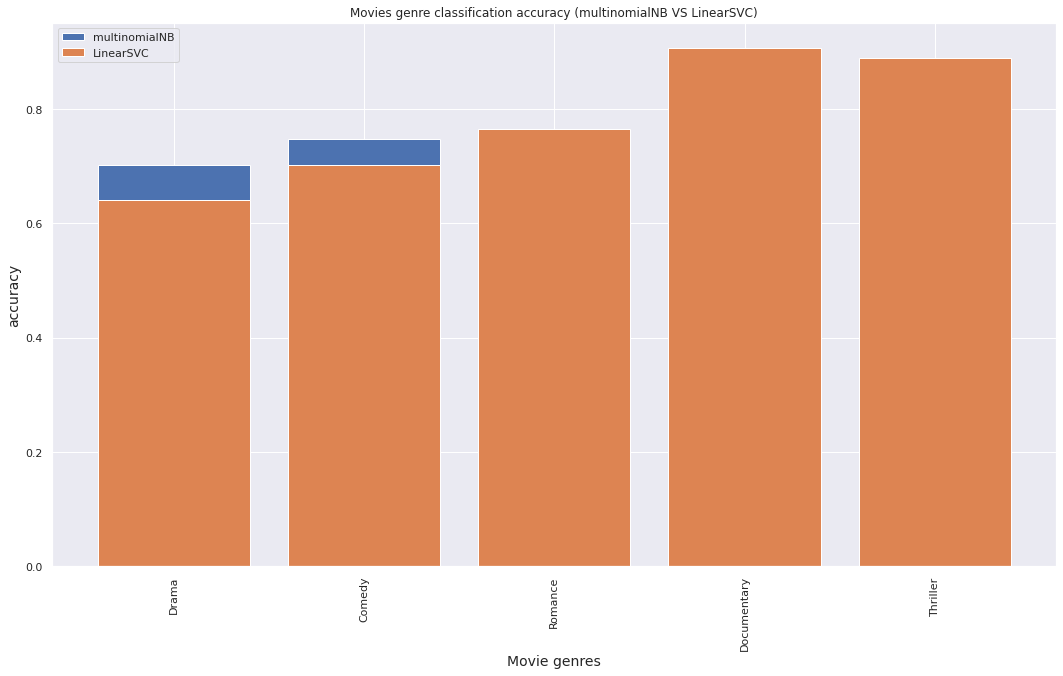

In [71]:
plt.figure(figsize=(18,10))
p1 =plt.bar(accuracy_svc_mnb.Genre, height=accuracy_svc_mnb.accuracy_multinomialNB)
p2 =plt.bar(accuracy_svc_mnb.Genre, height=accuracy_svc_mnb.accuracy_LinearSVC)
plt.xticks( rotation=90)
plt.title("Movies genre classification accuracy (multinomialNB VS LinearSVC)")
plt.ylabel('accuracy', fontsize=14)
plt.xlabel('Movie genres', fontsize=14)
plt.legend((p1[0], p2[0]), ('multinomialNB', 'LinearSVC'))
plt.show()

As we can see, the above graph is not showing the comparison between the 2 classifiers. That's why we did another type of graph below.

In [72]:
accuracy_multinomialNB

,Genre,accuracy_multinomialNB
0,Drama,0.702406
1,Comedy,0.748431
2,Romance,0.76046
3,Documentary,0.903766
4,Thriller,0.884937


In [73]:
#accuracy_multinomialNB, accuracy_LinearSVC
accuracy_multinomialNB1 = accuracy_multinomialNB.copy()
accuracy_multinomialNB1.columns = ['Genre', 'accuracy']
accuracy_multinomialNB1['classifier'] = 'multinomialNB'

In [74]:
accuracy_multinomialNB1

,Genre,accuracy,classifier
0,Drama,0.702406,multinomialNB
1,Comedy,0.748431,multinomialNB
2,Romance,0.76046,multinomialNB
3,Documentary,0.903766,multinomialNB
4,Thriller,0.884937,multinomialNB


In [75]:
##accuracy_LinearSVC = accuracy_LinearSVC.drop(accuracy_LinearSVC.columns[-1],axis=1)
#accuracy_multinomialNB, accuracy_LinearSVC
accuracy_LinearSVC1 = accuracy_LinearSVC.copy()
accuracy_LinearSVC1.columns = ['Genre', 'accuracy']
accuracy_LinearSVC1['classifier'] = 'linearSVC'

In [76]:
accuracy_LinearSVC1

,Genre,accuracy,classifier
0,Drama,0.641736,linearSVC
1,Comedy,0.701883,linearSVC
2,Romance,0.76569,linearSVC
3,Documentary,0.906381,linearSVC
4,Thriller,0.889121,linearSVC


In [77]:
accu_mnb_svc = accuracy_multinomialNB1.append(accuracy_LinearSVC1)

In [78]:
accu_mnb_svc

,Genre,accuracy,classifier
0,Drama,0.702406,multinomialNB
1,Comedy,0.748431,multinomialNB
2,Romance,0.76046,multinomialNB
3,Documentary,0.903766,multinomialNB
4,Thriller,0.884937,multinomialNB
0,Drama,0.641736,linearSVC
1,Comedy,0.701883,linearSVC
2,Romance,0.76569,linearSVC
3,Documentary,0.906381,linearSVC
4,Thriller,0.889121,linearSVC


[Text(0, 0, 'Drama'),
 Text(0, 0, 'Comedy'),
 Text(0, 0, 'Romance'),
 Text(0, 0, 'Documentary'),
 Text(0, 0, 'Thriller')]

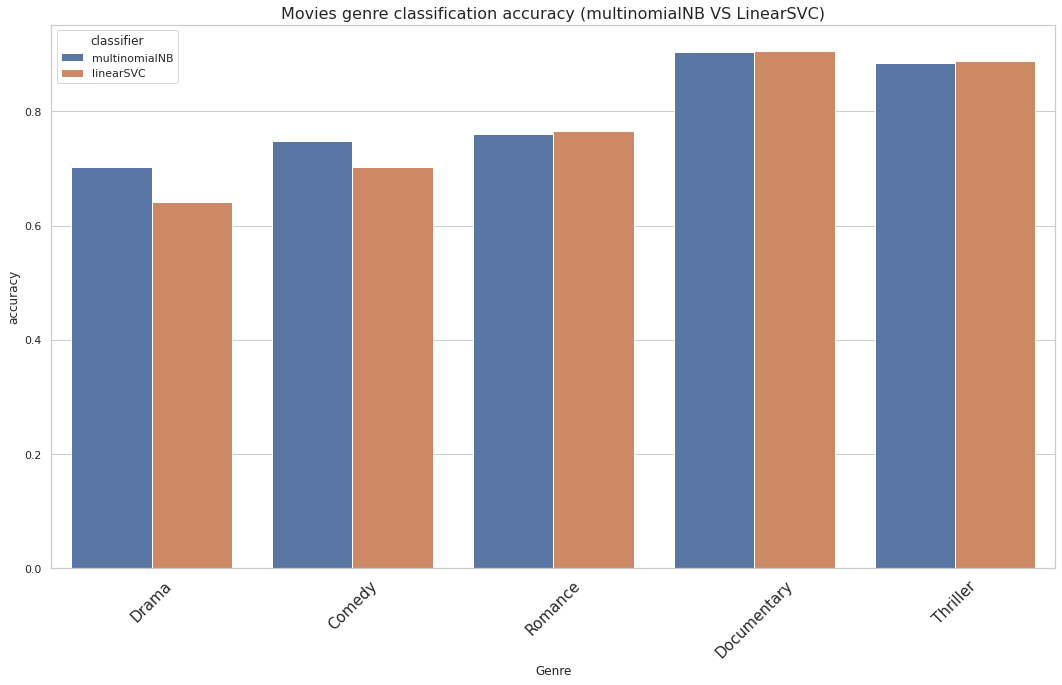

In [79]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(style="whitegrid")
s = sns.barplot(x="Genre", y="accuracy", hue="classifier", data=accu_mnb_svc) #.set_title('Movies genre classification accuracy (multinomialNB VS LinearSVC)')
s.set_title('Movies genre classification accuracy (multinomialNB VS LinearSVC)', size=16)
s.set_xticklabels(list(mainGenres) ,rotation=45, size=15)

It is indeed quite confusing to observe which one is better using different genres. Thus, we used f1 & accuracy score (an more overview visualisation) for the comparison. 

In [80]:
accuracy_f1.head()

,Algorithm,Score_Type,Score
1,MultinomailNB,Accuracy_Score,0.365063
2,MultinomailNB,F1_Score,0.676481
3,Linear_SVC,Accuracy_Score,0.310669
4,Linear_SVC,F1_Score,0.620652


Text(0.5, 1.0, 'F1 & accuracy score (multinomialNB VS LinearSVC)')

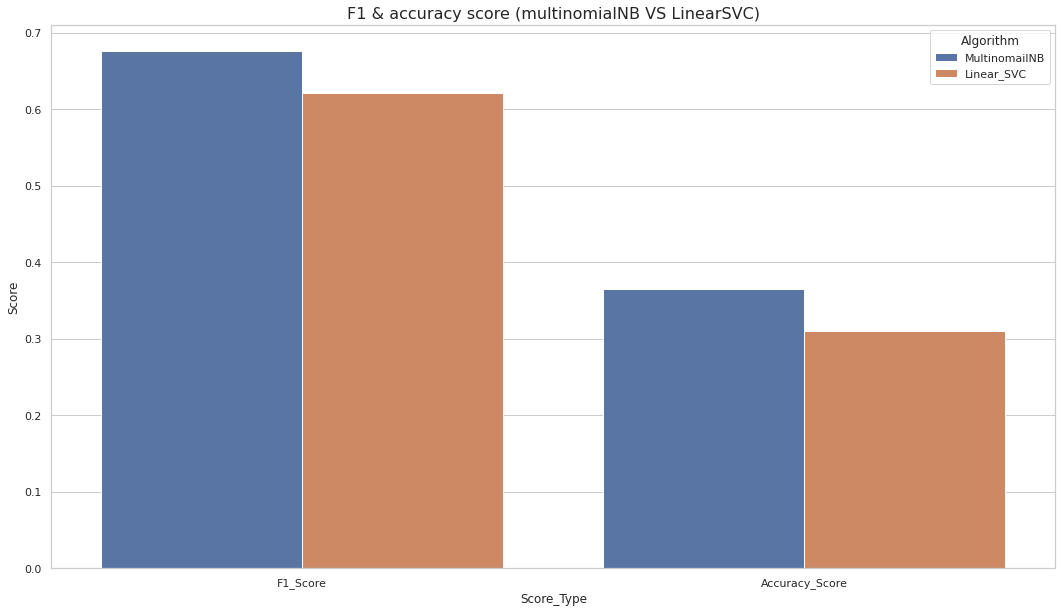

In [81]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(style="whitegrid")
s = sns.barplot(x="Score_Type", y="Score", hue="Algorithm", data=accuracy_f1, order=['F1_Score','Accuracy_Score']) #.set_title('Movies genre classification accuracy (multinomialNB VS LinearSVC)')
s.set_title('F1 & accuracy score (multinomialNB VS LinearSVC)', size=16)

####**5. Conclusion**
**Below are the main conclusions of this kernel:**

Both algorithms MultinomialNB and LinearSVC showed not bad accuracy rate even though LinearSVC did not success to converge for some genre. The lowest accuracy rate (per genre) is arond 65% and the best accuracy rate above 90%.
Multinomial Naive Bayes Classification is hacing a slightly higher scores and much faster compared to LinearSVC. In addition, it has no convergence issues. So, we would recommend it for ONLY for this case of movie genre classifications.
